In [2]:
import h5py, os

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import ecog
from ecog.utils.electrodes import load_electrode_labels
from ecog.signal_processing import hilbert_transform, gaussian
from ecog.tokenize.transcripts import parse, make_df
from ecog.utils import bands
from ecog.signal_processing import zscore

In [3]:
subj_path = os.path.join(os.environ['HOME'], 'Development/data/ecog/EC2')
block = 'EC2_B1'
block_path = os.path.join(subj_path, block)

anatomy = load_electrode_labels(subj_path)
vsmc_idxs = np.array([idx for idx, a in enumerate(anatomy) if a in ['preCG', 'postCG']])

ec2_b1_transcript_parse = parse(block_path, block)
ec2_b1_transcript = make_df(ec2_b1_transcript_parse, 1, 'EC2', 1)

idx = (ec2_b1_transcript['label'] == 'raa').argmax()
align = ec2_b1_transcript['align'].loc[idx]

rate = 400
start_idx = int(rate * (align-.5))
stop_idx = int(rate * (align + .8))
sl = slice(start_idx, stop_idx)

In [4]:
with h5py.File(os.path.join(block_path, 'ecog400/ecog.h5')) as f:
    raw_vsmc_data = f['ecogDS/data'][sorted(vsmc_idxs)]
vsmc_data, means, stds = zscore(raw_vsmc_data, mode='file', sampling_freq=400., block_path=block_path)
baa_data = vsmc_data[:, sl]

# Electrodes by time

In [42]:
def plot_electrodes_by_time(data, ax):
    n_elec, n_time = data.shape
    cmap = matplotlib.cm.get_cmap('Reds')
    cs = [cmap(x) for x in np.linspace(.5, 1, n_elec)]
    x = np.linspace(-500, 800, n_time)
    for ii in range(n_elec):
        y = data[ii] / 3
        ax.plot(x, y + ii, c=cs[ii], lw=3)
    ax.set_xticks([-500, 0, 800])
    ax.set_yticks([])
    ax.set_yticklabels([None])
    ax.set_ylabel('Electrodes')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

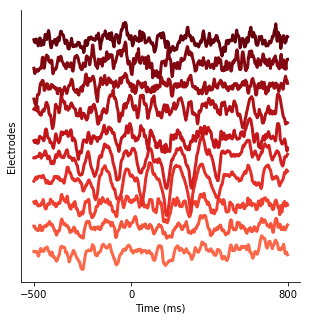

In [49]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
plot_electrodes_by_time(baa_data[15:25], ax)
plt.savefig('/home/jesse/Downloads/electrodes.pdf')

# Bandpassed electrode

In [51]:
def plot_40bands_by_time(data, band_idxs, sl, ax):
    cmap = matplotlib.cm.get_cmap('Reds')
    n_idxs = len(band_idxs)
    cs = [cmap(x) for x in np.linspace(.5, 1, n_idxs)]

    cfs = bands.chang_lab['cfs']
    stds = bands.chang_lab['sds']
    filters = [gaussian(data, rate, cfs[idx], stds[idx]) for idx in band_idxs]
    ht = np.squeeze(abs(hilbert_transform(data, rate, filters)))
    ht, means, stds = zscore(ht, mode='file', sampling_freq=400., block_path=block_path)
    ht = ht[:, sl]
    x = np.linspace(-500, 800, ht.shape[1])
    for ii in range(n_idxs):
        y = ht[ii] / 2
        ax.plot(x, y + ii, c=cs[ii], lw=3)
    ax.set_xticks([-500, 0, 800])
    ax.set_yticks(np.arange(n_idxs)[::3])
    ax.set_yticklabels(cfs.astype(int)[band_idxs][::3])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

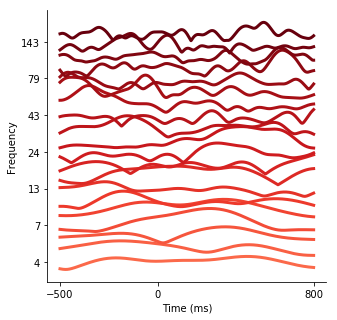

In [52]:
elec_idx = 19
elec_data = vsmc_data[[elec_idx]]
band_idxs = np.arange(0, 40, 2)

plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
plot_40bands_by_time(elec_data, band_idxs, sl, ax)
plt.savefig('/home/jesse/Downloads/frequencies.pdf')

# Neuro bands

In [53]:
def plot_neurobands_by_time(data, sl, ax):
    cmap = matplotlib.cm.get_cmap('Reds')
    n_bands = len(bands.neuro['bands'])
    cs = [cmap(x) for x in np.linspace(.5, 1, n_bands)]
    cfs = bands.chang_lab['cfs']
    stds = bands.chang_lab['sds']
    
    for ii, (minf, maxf) in enumerate(zip(bands.neuro['min_freqs'], bands.neuro['max_freqs'])):
        filters = [gaussian(data, rate, c, s) for c, s in zip(cfs, stds) if ((c >= minf) and (c <= maxf))]
        ht = np.squeeze(abs(hilbert_transform(data, rate, filters)))
        ht, m, s = zscore(ht, mode='file', sampling_freq=400., block_path=block_path)
        ht = ht[:, sl].mean(axis=0) / 2
        x = np.linspace(-500, 800, ht.size)
        ax.plot(x, ht + ii, c=cs[ii], lw=3)
    ax.set_xticks([-500, 0, 800])
    ax.set_yticks(np.arange(n_bands))
    ax.set_yticklabels([r'$\theta$', r'$\alpha$', r'low $\beta$', r'high $\beta$', r'$\gamma$', r'high $\gamma$'])
    ax.set_ylabel('Frequency band')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

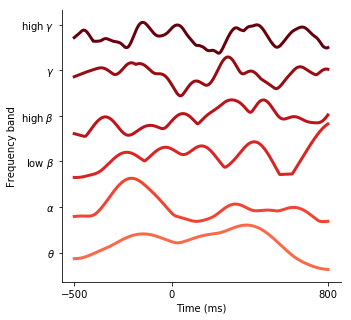

In [54]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
plot_neurobands_by_time(elec_data, sl, ax)
plt.savefig('/home/jesse/Downloads/bands.pdf')

# Dataset

In [ ]:
def plot_datapoint(data, ax):
    cmap = matplotlib.cm.get_cmap('Reds')
    n_bands = len(bands.neuro['bands'])
    cs = [cmap(x) for x in np.linspace(.5, 1, n_bands)]
    cfs = bands.chang_lab['cfs']
    stds = bands.chang_lab['sds']
    
    minf = bands.neuro['min_freqs'][-1]
    maxf = bands.neuro['max_freqs'][-1]
    filters = [gaussian(data, rate, c, s) for c, s in zip(cfs, stds) if ((c >= minf) and (c <= maxf))]
    ht = np.squeeze(abs(hilbert_transform(data, rate, filters)))
    ht, m, s = zscore(ht, mode='file', sampling_freq=400., block_path=block_path)
    ht = ht[:, sl].mean(axis=0) / 2
    x = np.linspace(-500, 800, ht.size)
    ax.plot(x, ht + ii, c=cs[ii], lw=3)
    ax.set_xticks([-500, 0, 800])
    ax.set_yticks(np.arange(n_bands))
    ax.set_yticklabels([r'$\theta$', r'$\alpha$', r'low $\beta$', r'high $\beta$', r'$\gamma$', r'high $\gamma$'])
    ax.set_ylabel('Frequency band')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()